# Importation des modules

In [102]:
import numpy as np
import os
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime

# Définition des paramètres

### Paramètres géométriques

In [103]:
L_x, L_y = 10, 5 # Longueur et largeur de notre domaine d'étude
N_x, N_y = 500, 250 # Nombre de mailles selon x et selon y

Attention à ne pas confondre **nombre de mailles** et **nombre de points**.

Typiquement, on a choisi de représenter l'intervalle continu $[0, L_x]$ par l'intervalle discret de points $\llbracket 0, N_x \rrbracket$. Ainsi, il y a bien $N_x$ **mailles**, de la forme $[x_i, x_{i+1}]$, mais **Nx + 1 points**.

De même, selon y, il y a $N_y$ **mailles** et donc $N_y+1$ **points**.

In [104]:
dx = L_x/N_x # Taille d'une maille selon x
dy = L_y/N_y # Taille d'une maille selon y

### Paramètres physiques

Posons d'abord les conditions limites de notre problème.

In [105]:
T_0 = 293.15  # Température initiale du corps étudié, en Kelvin (20 °C)

# Il est conseillé de garder 20°C.

# En effet, la conductivité thermique, la masse volumique et la capacité thermique 
# d'un corps sont thermosensibles, et plus loin on les prendra à 20°C pour le cuivre et l'eau.

T_1 = 323.15  # Température imposée au bord y=0, en Kelvin (50°C)
T_a = 273.15  # Température ambiante du fluide en x=Lx, en Kelvin (0°C)

Profitons-en pour donner quelques valeurs courantes pour des corps physiques usuels. 

En vérité, toutes les grandeurs qui peuvent servir à caractériser le comportement thermique d'un matériau ($\lambda$, $\rho$, $c_p$) sont elles-même thermosensibles. Pour se simplifier la vie, on les supposera constantes et égales à leur valeur à 300 K.

*(source : Transferts thermiques - J. Taine, F. Enguehard, E. Iacona - Éditions Dunod)*

In [106]:
class CorpsPhysique:
    def __init__(self, name, lambd, rho, cp):
        self.name = name  # Nom du corps physique
        self.lambd = lambd  # Conductivité thermique en W/(m·K)
        self.rho = rho  # Densité en kg/m³
        self.cp = cp  # Capacité thermique en J/(kg·K)
    
    def a(self):
        return self.lambd / (self.rho * self.cp) # Diffusivité thermique en m²/s

cuivre = CorpsPhysique("cuivre", 399, 8954, 383)  # Cuivre à 20°C
eau = CorpsPhysique("eau", 0.585, 997, 4180)  # Eau à 20°C
air = CorpsPhysique("air", 0.0263, 1.1614, 1007)  # Air à 300 K

# Pour rajouter de nouveaux corps physiques, c'est ici.


Le calcul exact d'un coefficient de conducto-convection peut être délicat, et faire intervenir des nombres de Prandtl, Nusselt, la dilatation thermique et la gravité... Pour faire simple, nous imposerons un ordre de grandeur de h selon l'usage que l'on souhaite (h = 10 pour de la convection naturelle de l'air, h = 100 pour de la convection forcée de l'air, h = 1000 pour de la convection forcée de l'eau...)

In [107]:
# Si on veut changer le coefficient de convection extérieure, c'est ici.
h = 100 # en W/(m²·K)
# Étrangement, la résolution analytique marche mal pour h = 1000.

# Si on veut changer le corps étudié, c'est ici.
corps = cuivre
# Étrangement, la résolution analytique marche mal pour l'eau et l'air.

On peut en profiter pour réaliser un calcul du **nombre de Biot** selon chaque dimension : 
- $\displaystyle Bi_x = \frac{h L_x}{\lambda}$

- $\displaystyle Bi_y = \frac{h L_y}{\lambda}$

Ce nombre sans dimension évalue l'**importance de la convection par rapport à la conduction**, selon une dimension.

In [108]:
lambd = corps.lambd

# Calcul du nombre de Biot selon x
Bi_x = h * L_x / lambd
print(f"Nombre de Biot selon x: {Bi_x:.2f}")

# Calcul du nombre de Biot selon y
Bi_y = h * L_y / lambd
print(f"Nombre de Biot selon y: {Bi_y:.2f}")

Nombre de Biot selon x: 2.51
Nombre de Biot selon y: 1.25


# Résolution numérique

Nous allons implémenter la méthode ADI.

In [109]:
dt = 1000 # Choix du pas de temps de notre simulation
N_t = 500000 # Temps maximal de notre simulation

In [110]:
a = corps.a()

# Calcul du temps caractéristique de conduction selon x
t_cond_x = L_x**2 / a
print(f"Temps caractéristique de conduction selon x: {t_cond_x:.2f}")

# Calcul du temps caractéristique de conduction selon y
t_cond_y = L_y**2 / a
print(f"Temps caractéristique de conduction selon y: {t_cond_y:.2f}")

print()

# Calcul du temps caractéristique de convection selon x
t_conv_x = t_cond_x / h
print(f"Temps caractéristique de convection selon x: {t_conv_x:.2f}")

# Calcul du temps caractéristique de convection selon y
t_conv_y = t_cond_y / h
print(f"Temps caractéristique de convection selon y: {t_conv_y:.2f}")

print()

# Calcul du nombre de Fourier selon x
Fo_x = a * dt / dx**2
print(f"Nombre de Fourier selon x: {Fo_x:.5f}")

# Calcul du nombre de Fourier selon y
Fo_y = a * dt / dy**2
print(f"Nombre de Fourier selon y: {Fo_y:.5f}")

Temps caractéristique de conduction selon x: 859494.24
Temps caractéristique de conduction selon y: 214873.56

Temps caractéristique de convection selon x: 8594.94
Temps caractéristique de convection selon y: 2148.74

Nombre de Fourier selon x: 290.86873
Nombre de Fourier selon y: 29086.87338


L'objectif de la méthode ADI est d'obtenir des matrices tridiagonales, qui sont particulièrement simples à inverser via l'algorithme TDMA. On le définit ici :

In [111]:
def TDMA(sous_diag, diag, sur_diag, droite):
    """
    Algorithme TDMA (ou algorithme de Thomas) pour résoudre un système de la forme Ax = b
    où A est une matrice tridiagonale (avec comme diagonales sous_diag, diag et sur_diag)
    et b est un vecteur (droite).
    """
    a = np.copy(sous_diag)
    b = np.copy(diag)
    c = np.copy(sur_diag)
    d = np.copy(droite)
    
    n = len(d)
    w = np.zeros(n-1,float)
    g = np.zeros(n, float)
    x = np.zeros_like(d)

    # Première étape : décomposition LU

    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])

    # Deuxième étape : substitution en arrière
    x[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        x[i-1] = g[i-1] - w[i-1]*x[i]

    return x

In [112]:
def compute_XY(_L_x = L_x, _L_y = L_y, _N_x = N_x, _N_y = N_y):
    x_values = np.linspace(0, _L_x, _N_x + 1)
    y_values = np.linspace(0, _L_y, _N_y + 1)
    X, Y = np.meshgrid(x_values, y_values)
    return X, Y

X, Y = compute_XY()

def plot_temperature(title, T, contour = True, _X = X, _Y = Y):
    fig, ax = plt.subplots(figsize=(12, 6))
    #if meshgrid:
    #    im = ax.imshow(T, cmap='turbo', origin='lower', extent=[0, L_x, 0, L_y], edgecolors='k', linewidths=0.2)
    #else:
    im = ax.imshow(T, cmap='turbo', origin='lower', extent=[0, L_x, 0, L_y])
    fig.colorbar(im, ax=ax, label='Température (K)', pad=0.1)
    plt.title(title, fontsize = 16) 
    ax.set_xlabel('x', fontsize = 16)
    ax.set_ylabel('y', fontsize = 16)

    # Ajout des lignes de contour
    if contour:
        contours = ax.contour(_X, _Y, T, levels = [300, 305, 310, 315, 320, 321, 322, 323], linewidths= 1, colors=['white', 'black', 'black', 'black', 'white', 'black', 'black', 'black'])
        ax.clabel(contours, inline=True, fontsize=12, fmt = '%d', inline_spacing = 10)

On initialise ensuite le profil de température ```T``` en $t=0$.

Attention ! Dans le fonctionnement de ```pyplot```, ```T[i,j]``` représentera la température en $T_{i,j}$, avec $i$ en **abscisse** et $y$ en **ordonnée**.

Or, si on initialise un tableau numpy pour qu'il ait la taille ```(x1, x2)```, 
il aura alors ```x1``` **lignes** et ```x2``` **colonnes**.

Cela va à l'encontre de l'intuition souhaitée ! On peut se référer au schéma pour s'en convaincre, on souhaite avoir ```N_y + 1``` lignes (ordonnées) et  ```N_x + 1``` colonnes (abscisses)

In [113]:
# Initialisation en t=0
T = np.full((N_y + 1, N_x + 1), T_0)

# Conditions aux limites : dès que t>0, on impose T(x, 0) = T_1.
# En fait c'est aussi dans le format T[i,j] que c'est pas intuitif, bref.
# Faut raisonner à l'envers et dire que T[y, x] c'est T(x, y).

T[0, :] = T_1

Nous allons en parallèle enregistrer chaque image afin de pouvoir faire une animation. Nous pouvons initialiser la figure avec le profil de température à l'état initial.

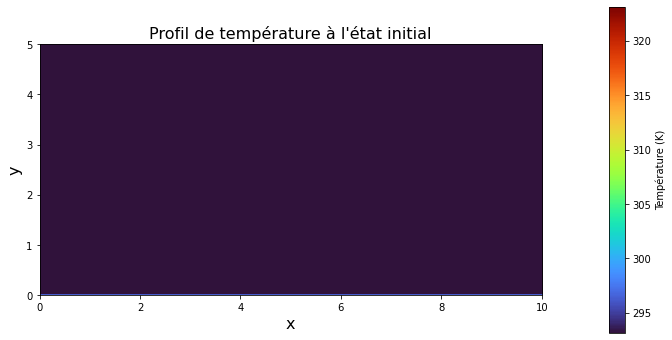

In [114]:
plot_temperature("Profil de température à l'état initial", T, False, True)
plt.show()

In [115]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the folder path
folder_path = os.path.join("output", current_time)

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


La méthode ```ADI_method``` va ensuite prendre à chaque étape t la valeur du tableau à cet instant, et le modifier selon la méthode ADI.

In [116]:
def methode_ADI(_T = T):
    t = 0
    images = []

    fig, ax = plt.subplots(figsize=(12, 6))  
    im = ax.imshow(_T, cmap='turbo', origin='lower', extent=[0, L_x, 0, L_y])
    fig.colorbar(im, ax=ax, label='Température (K)', pad=0.1)
    ax.set_xlabel('x', fontsize = 16)
    ax.set_ylabel('y', fontsize = 16)
    title = ax.text(0.5, 1.05, f"Profil de température à l'étape t = {t}", size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes)
    images.append([im, title])

    while t < N_t:
        T_n = np.copy(_T)
        
        # Étape 1 : résoudre dans la direction x
        sous_diag = np.full(N_x, -Fo_x/2)
        sous_diag[-1] = -Fo_x

        diag = np.full(N_x + 1, 1 + Fo_x)
        diag[-1] += (Fo_x/2) * (h * dx / lambd)

        sur_diag = np.full(N_x, -Fo_x/2)
        sur_diag[0] = -Fo_x

        for j in range(1, N_y + 1):
            droite = T_n[j, :]
            droite[-1] += (Fo_x/2) * (h * dx / lambd) * T_a

            _T[j, :] = TDMA(sous_diag, diag, sur_diag, droite)

        T_n_half = np.copy(_T)

        # Étape 2 : résoudre dans la direction y
        sous_diag = np.full(N_y - 1, -Fo_y/2)
        sous_diag[-1] = -Fo_y

        diag = np.full(N_y, 1 + Fo_y)

        sur_diag = np.full(N_y - 1, -Fo_y/2)

        for i in range(0, N_x + 1):
            droite = T_n_half[1:, i]
            droite[0] += (Fo_y/2) * T_1

            _T[1:, i] = TDMA(sous_diag, diag, sur_diag, droite)

        # On incrémente le temps
        t += dt

        # On met à jour l'image à chaque étape
        im = ax.imshow(_T, cmap='turbo', origin='lower', extent=[0, L_x, 0, L_y])

        # Titre de la figure à l'instant t
        title = ax.text(0.5, 1.05, f"Profil de température à l'étape t = {t}", size=plt.rcParams["axes.titlesize"], ha="center", transform=ax.transAxes)

        images.append([im, title])

    # Créer l'animation à partir des images
    animatedPlot = animation.ArtistAnimation(fig, images, interval=50, blit=True)

    # Enregistrer l'animation au format MP4
    animatedPlot.save(f'{folder_path}/animation_Fx+Fy={Fo_x+Fo_y:.2f}.mp4', writer='ffmpeg')
    
    return _T

KeyboardInterrupt: 

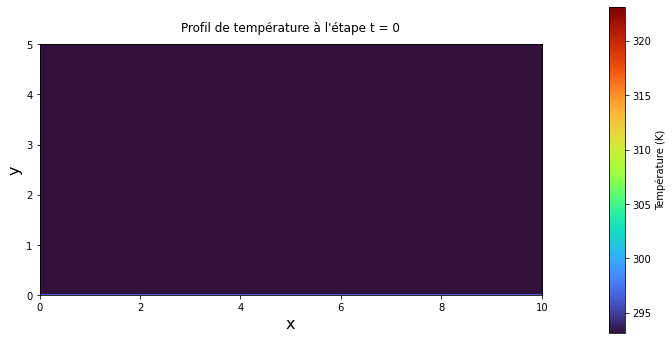

In [117]:
T_numerique = methode_ADI()

plot_temperature(f'Profil numérique de la température après {N_t} étapes', T_numerique)
plt.savefig(f'{folder_path}/numerique_Nx={N_x}_Ny={N_y}.png')
plt.show()

# Résolution analytique

L'énoncé indique que la solution analytique est donnée par la formule suivante :

$\displaystyle T(x,y) = T_a + \frac{2h}{\lambda} (T_1 - T_a) \sum_{n=1}^\infty \frac{\cos(\alpha_n x) \cosh(\alpha_n (L_y - y))}{[(\alpha_n^2 + \beta^2) L_x + \beta] \cos(\alpha_n L_x) \cosh(\alpha_n L_x)}$

où $\alpha_n$ désigne la nième solution positive de l'équation $\alpha \tan(L_x \alpha) = \beta = \displaystyle \frac{h}{\lambda}$.

Commençons donc par rédiger une fonction qui, à $n$ donné, permet d'obtenir $\alpha_n$. C'est une équation non-linéaire, on est contraint d'utiliser un algorithme de résolution numérique.

In [ ]:
beta = h / lambd

def f(alpha):
    # Fonction dont on cherche les zéros
    return alpha * np.tan(L_x * alpha) - beta

C'est une équation non-linéaire, on va devoir utiliser un algorithme de résolution numérique.
Le module ```scipy.optimize``` propose la fonction ```fsolve``` qui est une variante de l'algorithme de Newton-Raphson.
De tels algorithmes ont besoin d'une **estimation initiale** de la solution avant de chercher.
On peut montrer, avec les propriétés de la fonction $\tan$, que : 
- la première racine de l'équation $f(a) = 0$ sera située avant $\frac{\pi}{2L_x}$, et que donc on peut commencer par placer le curseur à $\frac{\pi}{4L_x}$.
- la $n$-ième racine sera proche de $\frac{n \pi}{L_x}$, et que donc ceci en constitue une bonne estimation.

In [ ]:
def n_premieres_solutions(n):
    # Liste pour stocker les solutions
    solutions = []

    # Estimation initiale de la solution
    x_0 = np.pi / (4 * L_x)
    nb_solutions = 0

    while nb_solutions < n:
        solution = fsolve(f, x_0)[0]

        # Si la solution est déjà dans la liste, l'ignorer
        if solution in solutions:
            x_0 += np.pi / L_x
            continue

        # Ajout de la solution à la liste
        solutions.append(solution)

        nb_solutions += 1
        x_0 = nb_solutions * np.pi / L_x

    return solutions

# Étrangement, ce programme a du mal lorsqu'on met l'air comme matériau...
# Un print des solutions peut aider à voir que les alpha_n sont n'importe quoi.

On a de quoi obtenir les $n$ premières valeurs de $\alpha_n$. 

Rappelons qu'on cherche à calculer la série :

$\displaystyle T(x,y) = T_a + \frac{2h}{\lambda} (T_1 - T_a) \sum_{n=1}^\infty \frac{\cos(\alpha_n x) \cosh(\alpha_n (L_y - y))}{[(\alpha_n^2 + \beta^2) L_x + \beta] \cos(\alpha_n L_x) \cosh(\alpha_n L_x)}$

Deux approches sont alors possibles pour calculer une somme s'approchant au plus de cette série :
- On se fixe un nombre de termes ```N``` que l'on considère comme suffisamment grand. Par exemple, ```N = 100```.
- On fait l'hypothèse que le terme général n'oscille pas trop et que donc, si l'on trouve une première occurence bornée par une tolérance donnée ```epsilon```, alors on peut s'arrêter là. 

In [ ]:
# On peut ici choisir si l'on préfère le mode "jusqu'à N termes" ou "jusqu'à un terme epsilon"
type_boucle = "while" # ou "for"

# Si on veut changer le nombre de termes de la série à calculer, c'est ici.
N = 100

# Si on veut changer la valeur à partir de laquelle on s'arrête de calculer des termes de la série, c'est ici.
epsilon = 1e-5

Cette série est donnée comme convergente, ainsi on sait que son terme général tend vers 0 et que donc, pour tout $\varepsilon > 0$, il existe une valeur $N_\varepsilon$ telle que le terme général devient dominé par $\varepsilon$ à partir du terme $N_\varepsilon$. Quelle que soit l'approche choisie, elle sera donc à peu près correcte, même si on ne réalise pas de preuve mathématique pour borner l'erreur. Procédons :

In [ ]:
def serie(x, y, _L_x = L_x, _L_y = L_y, _beta = beta, _N = N, _epsilon = epsilon):
    somme = 0
    if type_boucle == "for":
        liste_alphas = n_premieres_solutions(N)
        for k in range(1, N+1):
            alpha_k = liste_alphas[k-1]
            terme_k = np.cos(alpha_k * x) * np.cosh(alpha_k * (_L_y - y)) / (((alpha_k**2 + _beta**2) * _L_x + _beta) * np.cos(alpha_k * _L_x) * np.cosh(alpha_k * _L_y))
            somme += terme_k

    elif type_boucle == "while":
        k = 1
        liste_alphas = n_premieres_solutions(N)
        k_max = len(liste_alphas)

        while True:
            if k > k_max:
                k_max *= 2
                liste_alphas = n_premieres_solutions(k_max)
            alpha_k = liste_alphas[k-1]
            # Processus dynamique plus efficace pour le calcul de solutions que 
            # alpha_k = n_premieres_solutions(k)[-1] qui recalcule tout à chaque fois

            terme_k = np.cos(alpha_k * x) * np.cosh(alpha_k * (_L_y - y)) / (((alpha_k**2 + _beta**2) * _L_x + _beta) * np.cos(alpha_k * _L_x) * np.cosh(alpha_k * _L_y))
            if abs(terme_k) < _epsilon:
                break
            somme += terme_k
            k += 1
    else:
        return "Type de boucle non reconnu."
    return somme

def T_analytique(x, y, _h = h, _lambd = lambd, _T_1 = T_1, _T_a = T_a):
    return _T_a + 2 * _h / _lambd * (_T_1 - _T_a) * serie(x, y)

Ainsi, ```T_analytique(x,y)``` renvoie bien le $T(x,y)$ voulu, du moins avec une certaine précision.

In [ ]:
def compute_T_analytique(_X = X, _Y = Y):
    T = np.vectorize(T_analytique)(X, Y)
    return T

T_analytique = compute_T_analytique()

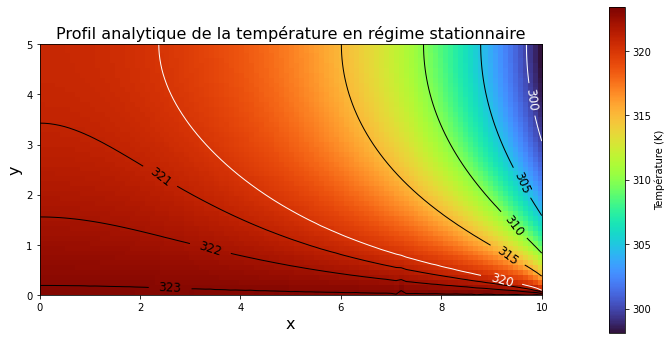

In [ ]:
plot_temperature('Profil analytique de la température en régime stationnaire', T_analytique)
plt.savefig(f'{folder_path}/analytique_tol={epsilon}.png')
plt.show()

Le profil observé est bien cohérent avec les conditions de notre problème : 
- la température est uniforme et maximale en $y=0$
- et se refroidit graduellement avec un flux convectif en $x=L_x$. 

De plus, on voit grâce aux isovaleurs que le flux thermique normal aux murs isolants, en $x=0$ et en $y=L_y$, est bien nul.

In [ ]:
def plot_difference(title, data, contour = True, _X = X, _Y = Y):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Find the maximum absolute value in the data
    vmax = np.max(np.abs(data))

    # Use a diverging color map and add a colorbar
    im = ax.imshow(data, cmap='seismic', origin='lower', extent=[0, L_x, 0, L_y], vmin=-vmax, vmax=vmax)
    fig.colorbar(im, ax=ax, label='Différence de température (K)', pad=0.1)

    plt.title(title, fontsize = 16) 
    ax.set_xlabel('x', fontsize = 16)
    ax.set_ylabel('y', fontsize = 16)

    if contour:
        contours = ax.contour(_X, _Y, data, levels = [-5, -3, -1, 0, 1], linewidths= 1, colors=['white', 'white', 'white', 'black', 'black'])
        ax.clabel(contours, inline=True, fontsize=12, fmt = '%d', inline_spacing = 10)

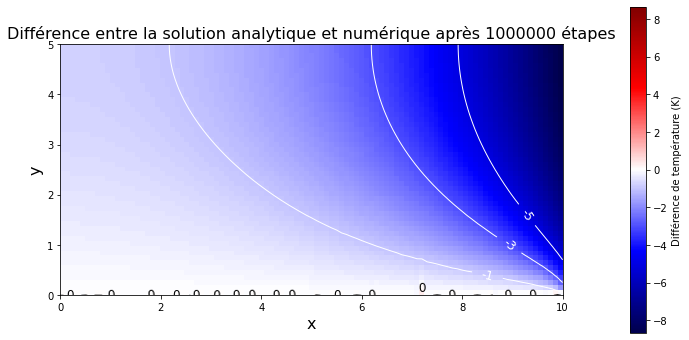

In [ ]:
T_delta = T_analytique - T_numerique

plot_difference(f'Différence entre la solution analytique et numérique après {N_t} étapes', T_delta)
plt.savefig(f'{folder_path}/delta_tConvX={t_conv_x:.2f}_tCondY={t_cond_y:.2f}.png')
plt.show()